In [70]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [71]:
# Bigger font
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')
# Figure size®
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 2.5
rcParams['lines.marker'] = '.'
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 10
rcParams['axes.titlesize'] = 16
# plt.rc('figure.subplot', wspace=.33)
# Slides
from notebook.services.config import ConfigManager
cm = ConfigManager()
# cm.update('livereveal', {'width': 1024, 'height': 768, 'scroll': True, 'theme': 'simple', 'transition': 'linear'});
# np.random.seed(123)

## Kernels / Covariance Functions

Each function is suitable for some applications.

## Squared exponential kernel / RBF kernel

$$
k(\mathbf{x},\mathbf{x'}) = \sigma^2 \text{exp} \left( - \frac{\|\mathbf{x} - \mathbf{x'} \|}{2l^2} \right)
$$

- Lengthscale:  If the lengthscale is large, training points that are far away also remain strongly correlated. Therefore, this leads to smooth functions.

- Variance: This doesn't affect smoothness. As the variance parameter increases, the variance of the sampled functions also increases.

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


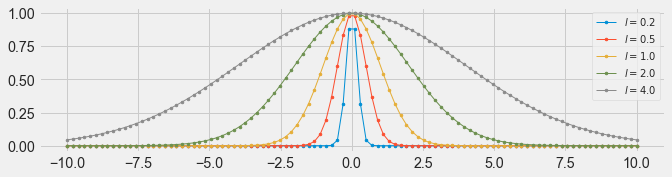

In [72]:
import GPy

# 1-dimensional
d = 1

# by default, all the parameters are set to 1. for the RBF kernel
k = GPy.kern.RBF(d)
print(k)

# we experiment with different length scale parameter values here
lengthscale = np.asarray([0.2,0.5,1.,2.,4.])

# create an instance of a figure
fig = plt.figure()
ax = plt.subplot(111)

# iterate over the lengthscales
for t in lengthscale:
    k.lengthscale=t
    x = np.linspace(-10,10,100)
    y = [k.K(np.array([[xi]]),np.array([[0.0]])).item() for xi in x]
    plt.plot(x, y)
    
ax.legend(["$l = {}$".format(i) for i in lengthscale])

This is the kernel output after receiving vectors as inputs (which is essentially a distance)

In [73]:
k.K(np.array([[2.0]]),np.array([[0.0]]))

array([[0.8824969]])

## Combinations of covariance functions

Combine covariance functions using the sum and product operators, + and *.

* The sum of covariance functions is a valid covariance function:

$$
k(x, x') = k_1(x, x') + k_2(x, x')
$$

* The product of covariance functions is a valid covariance funciton:

$$
k(x, x') = k_1(x, x') k_2(x, x')
$$

## Example

  sum.              |  value  |  constraints  |  priors
  linear.variances  |    1.0  |      +ve      |        
  rbf.variance      |    2.0  |      +ve      |        
  rbf.lengthscale   |    1.0  |      +ve      |        


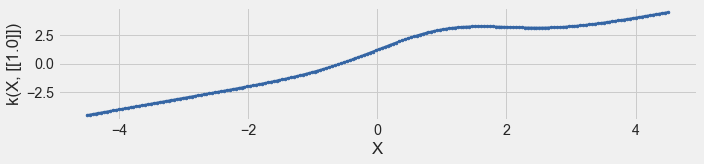

In [74]:
first_kernel = GPy.kern.Linear(1)
second_kernel = GPy.kern.RBF(1, variance=2., lengthscale=1)
kernel = first_kernel + second_kernel
print(kernel)
kernel.plot();

  mul.                      |  value  |  constraints  |  priors
  linear.variances          |    1.0  |      +ve      |        
  std_periodic.variance     |    1.0  |      +ve      |        
  std_periodic.period       |    1.0  |      +ve      |        
  std_periodic.lengthscale  |    1.0  |      +ve      |        


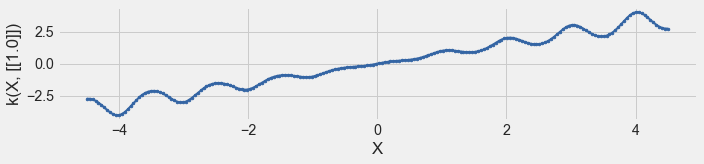

In [75]:
#### Linear times Periodic
kernel = GPy.kern.Linear(1) * GPy.kern.StdPeriodic(1)
print(kernel)
kernel.plot();

## Additive kernels

One of the popular approach to model the function of interest is
$$
f(x) = \sum_{i=1}^d f_i(x_i) + \sum_{i < j} f_{ij}(x_i, x_j) + \ldots
$$

**Example**: $\quad f(x_1, x_2) = f_1(x_1) + f_2(x_2)$  
To model it using GP use additive kernel $\quad k(x, x') = k_1(x_1, x'_1) + k_2(x_2, x'_2)$.

More general - add kernels each depending on subset of inputs
$$
k(x, x') = k_1(x, x') + \ldots + k_D(x, x'),
$$
where, for example, $k_1(x, x') = k_1(x_1, x_1'), \; k_2(x, x') = k_2((x_1, x_3), (x_1', x_3'))$, etc.



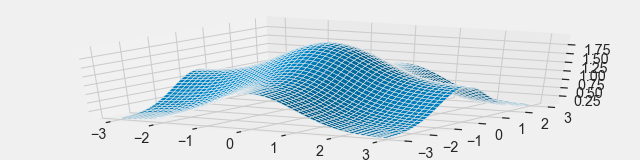

In [76]:
first_kernel = GPy.kern.RBF(1, active_dims=[0])
second_kernel = GPy.kern.RBF(1, active_dims=[1])

kernel = first_kernel + second_kernel

x = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
x = np.hstack((x[0].reshape(-1, 1), x[1].reshape(-1, 1)))
z = kernel.K(x, np.array([[0, 0]]))

figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(x[:, 0].reshape(50, 50), x[:, 1].reshape(50, 50), z.reshape(50, 50))
plt.show()

## Additive Model for Time Series

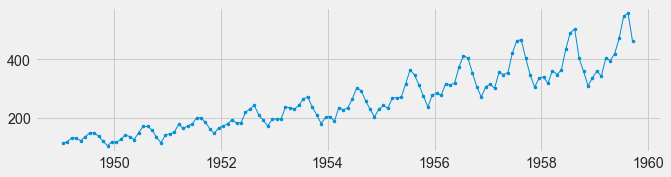

In [77]:
fname = 'data/AirPassengers_mod.csv'
data = pd.read_csv(fname)

from datetime import datetime
ts = data['Passengers']

x = data.Date.values[:, np.newaxis]
y = data.Passengers.values[:, np.newaxis]
plt.plot(x, y)

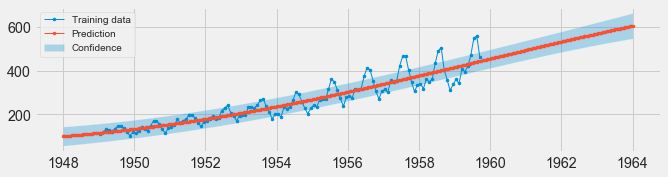

In [110]:
kernel_rbf = GPy.kern.RBF(1)
model = GPy.models.GPRegression(x, y, kernel_rbf)
model.optimize()

test_x = np.linspace(1948, 1964, 400).reshape(-1, 1)
prediction_mean, prediction_var = model.predict(test_x)
prediction_std = np.sqrt(prediction_var).ravel()
prediction_mean = prediction_mean.ravel()

plt.figure()
plt.plot(x, y, label='Training data')
plt.plot(test_x, prediction_mean, label='Prediction')
plt.fill_between(test_x.ravel(), prediction_mean - prediction_std,
                 prediction_mean + prediction_std, alpha=0.3, label='Confidence')
plt.legend()

## Additive Components

We will try to model this data set using 3 additive components: trend, seasonality and noise.  
So, the kernel should be a sum of 3 kernels:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`


Name : GP regression
Objective : 500.8467596474907
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  GP_regression.                    |                  value  |  constraints  |  priors
  sum.linear.variances              |   0.022999217298738293  |      +ve      |        
  sum.rbf.variance                  |      87.90173942769007  |      +ve      |        
  sum.rbf.lengthscale               |     0.5398476929134947  |      +ve      |        
  sum.mul.std_periodic.variance     |    0.19322734440994357  |      +ve      |        
  sum.mul.std_periodic.period       |      1.002636936543173  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |     0.4826035363070297  |      +ve      |        
  sum.mul.linear.variances          |    0.19322734439165537  |      +ve      |        
  sum.mul.rbf.variance              |    0.19322734499772978  |      +ve      |        
  sum.mul.rbf.lengthscale           |      10.73968692205152  | 

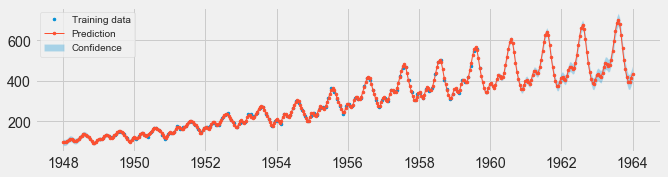

In [79]:
kernel_trend = GPy.kern.Linear(1) + GPy.kern.RBF(1) # trend
# kernel_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1) # trend
kernel_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.Linear(1) * GPy.kern.RBF(1) # periodicity
kernel_noise = GPy.kern.White(1) * GPy.kern.Linear(1) # noise

kernel = kernel_trend + kernel_periodicity + kernel_noise

model = GPy.models.GPRegression(x, y, kernel)
model.optimize()
print(model)

test_x = np.linspace(1948, 1964, 400).reshape(-1, 1)
prediction_mean, prediction_var = model.predict(test_x)
prediction_std = np.sqrt(prediction_var).ravel()
prediction_mean = prediction_mean.ravel()

plt.figure()
plt.plot(x, y, '.', label='Training data')
plt.plot(test_x, prediction_mean, label='Prediction')
plt.fill_between(test_x.ravel(), prediction_mean - prediction_std,
                 prediction_mean + prediction_std, alpha=0.3, label='Confidence')
plt.legend()